# **CSC461: Final Project**
## <u>Team Members:</u> *Javier Sin & Nicolás Pelegrín*
---

## 0. Data import and visualization

In [52]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
sns.set_style('darkgrid')

Dataset including 50k IMDB reviews for sentiment analysis. There's two columns: the first one is the reviews themselves and the second one is the sentiment of the review ('negative' || 'positive').

In [53]:
df_review = pd.read_csv("IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 1. Metrics

Now we'll cite the [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) we'll be using during the project:
* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
* [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)


* **Accuracy**: should be used when the classes are relatively balanced. If the dataset is imbalanced, accuracy can be misleading because the model may simply predict the majority class more often.
* **F1 score**: is the weighted average of precision and recall. It takes both false positives and false negatives into account. It is a better measure than accuracy for imbalanced datasets (not the case).
* **ROC-AUC**: this is a good metric for binary classification problems such us this one. It plots the true positive rate against the false positive rate. It is a good metric to use when the classes are imbalanced.

In this case, as we're going to use balanced datasets, we'll be using <u>accuracy</u> as our main metric. We'll also be using the <u>F1 score</u> to have a better understanding of the model's performance.

We're also going to define a **Panda's Dataframe** so that we can store the results obtained for each model in order to compare them at the end of this notebook.

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix

df = pd.DataFrame() # Global variable with the table storing the results of the models

def add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, method, comments):
    # Modifying a global variable inside a function must be done explicitly
    global df

    df_aux = pd.DataFrame(
        {
          "Method"    : [method],
          "accuracy_train" : [accuracy_score(y_train, y_train_prediction)],
          "accuracy_test" : [accuracy_score(y_test, y_test_prediction)],
          "f1_train" : [f1_score(y_train, y_train_prediction, pos_label='positive')],
          "f1_test" : [f1_score(y_test, y_test_prediction, pos_label='positive')],
          "Comments": [comments]
        }
    )

    df = pd.concat([df, df_aux], ignore_index=True)
    return df_aux

---
## 2. Preparing the data

Now we'll prepare the data for the models. First we'll split the data into training and testing sets. Then we'll use the `TfidfVectorizer` to convert the text data into a matrix of TF-IDF features, which will be used as input for the models.

In [55]:
from sklearn.model_selection import train_test_split

X = df_review['review']
y = df_review['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train.value_counts() # Checking the balance of the classes

sentiment
negative    20039
positive    19961
Name: count, dtype: int64

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [57]:
print(X_train.shape)
print(X_train_vect.shape)

(40000,)
(40000, 92692)


## 3. Models to be used

Our goal is to create and tune all the models in order to compare which one is the best for this particular dataset. Instead of just creating the default models and using the only one with best accuracy, we're going to tune them all and compare the results.

### 3.1: Decision Tree

The first model we're going to test is the [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

#### 3.1.1: Model creation

In [7]:
# Import the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Create the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train_vect, y_train)

# Predict the training set
y_train_prediction = dt.predict(X_train_vect)

# Predict the test set
y_test_prediction = dt.predict(X_test_vect)


In [9]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Decision Tree", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,1.0,0.7265,1.0,0.726363,Default parameters


As you can see, the current model with the default parameters suffers from `overfitting`. This can be deduced from the accuracy and f1 scores of 1.0 for the train sets. This means that the model is memorizing the training data patters and not generalizing well to the test data. We can solve this by tuning the hyperparameters of the model, and if this wouldn't be enough, we could also use some regularization techniques like `pruning`.

#### 3.1.2: Model tuning

Now we'll tune the model in order to avoid overfitting so that we can obtain better results.

In [10]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_dt = grid_search.best_estimator_

# Train the model with the best parameters
best_dt.fit(X_train_vect, y_train)

# Predict the training set
y_train_prediction = best_dt.predict(X_train_vect)

# Predict the test set
y_test_prediction = best_dt.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.801775
Test Accuracy: 0.7435


In [11]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}


Now I'll define a range of hyperparameters, for example for `max_depth` in order to see the different results in a plot to view how the model behaves and determine if it suffers from overfitting.

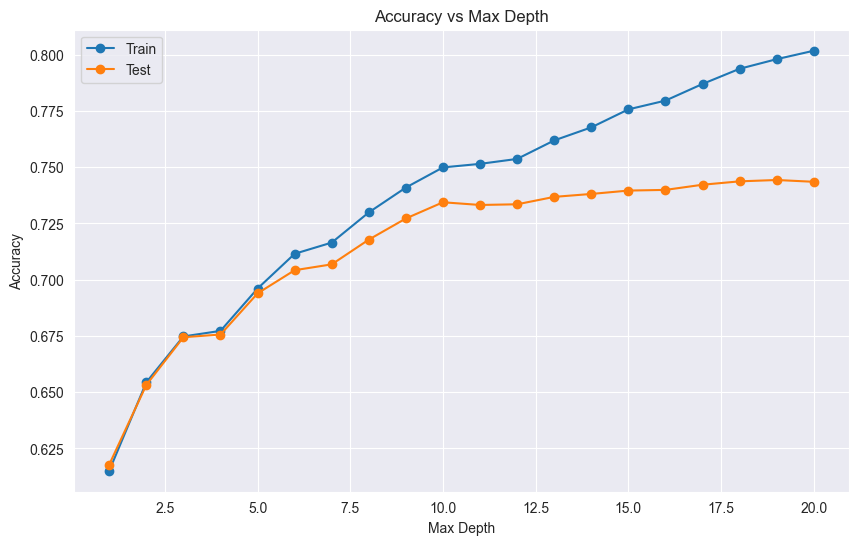

In [12]:
max_depths = range(1, 21)

train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=10, min_samples_split=2, random_state=42)
    dt.fit(X_train_vect, y_train)
    y_train_prediction = dt.predict(X_train_vect)
    y_test_prediction = dt.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, marker='o', label='Train')
plt.plot(max_depths, test_accuracies, marker='o', label='Test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

We have decided to cap the `max_depth` at 20 as the improvement is minimal after that point. Here's a summary of a test we did increasing the `max_depth` up to 30:

Max Depth: 18 - Train Acc: 0.79375 - Test Acc: 0.7437<br>
Max Depth: 19 - Train Acc: 0.798025 - Test Acc: 0.7442<br>
Max Depth: 20 - Train Acc: 0.801775 - Test Acc: 0.7434<br>
Max Depth: 21 - Train Acc: 0.803725 - Test Acc: 0.7424<br>
Max Depth: 22 - Train Acc: 0.80605 - Test Acc: 0.74<br>
Max Depth: 23 - Train Acc: 0.80945 - Test Acc: 0.7419<br>
Max Depth: 24 - Train Acc: 0.8131 - Test Acc: 0.7436<br>
Max Depth: 25 - Train Acc: 0.8159 - Test Acc: 0.7441<br>
Max Depth: 26 - Train Acc: 0.819375 - Test Acc: 0.7446<br>
Max Depth: 27 - Train Acc: 0.82075 - Test Acc: 0.7438<br>
Max Depth: 28 - Train Acc: 0.82405 - Test Acc: 0.7429<br>
Max Depth: 29 - Train Acc: 0.826275 - Test Acc: 0.7436<br>
Max Depth: 30 - Train Acc: 0.828425 - Test Acc: 0.7454<br>

As you can see, the model just improves in the train set for 0.02 in terms of accuracy, and the test set remains almost the same. Due to this along with the computation time required when increasing the `max_depth`, we decided to cap it at 20. 

In [13]:
best_dt_model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=2, random_state=42)
best_dt_model.fit(X_train_vect, y_train)

y_train_prediction = best_dt_model.predict(X_train_vect)
y_test_prediction = best_dt_model.predict(X_test_vect)

add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Decision Tree", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,0.801775,0.7435,0.813457,0.759449,Best parameters found by GridSearchCV


Regarding at the results, this time we see that the **model is not overfitting anymore**, as the accuracy and f1 scores are quite similar for the train and test sets. This means that the model is generalizing well to the test data.

### 3.2: Naive Bayes

The second model we're going to test is the [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

Note that even though the classification is a binary one, we're using the `MultinomialNB` class because it's the one that works best with the `TfidfVectorizer` we're using.

#### 3.2.1: Model creation

In [14]:
# Import the Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

In [15]:
# Create the Naive Bayes Classifier
nb = MultinomialNB()

# Train the model
nb.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = nb.predict(X_train_vect)
y_test_prediction = nb.predict(X_test_vect)

# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Naive Bayes", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Naive Bayes,0.9064,0.8652,0.904975,0.864604,Default parameters


#### 3.2.2: Model tuning

In [16]:
# Find the best alpha using GridSearchCV
param_grid = {
    'alpha': np.linspace(0.1, 1, 20)
}

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_nb = grid_search.best_estimator_

# Train the model with the best parameters
best_nb.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = best_nb.predict(X_train_vect)
y_test_prediction = best_nb.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.916975
Test Accuracy: 0.864


In [17]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'alpha': np.float64(0.4789473684210527)}


In [18]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Naive Bayes", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Naive Bayes,0.916975,0.864,0.915909,0.863891,Best parameters found by GridSearchCV


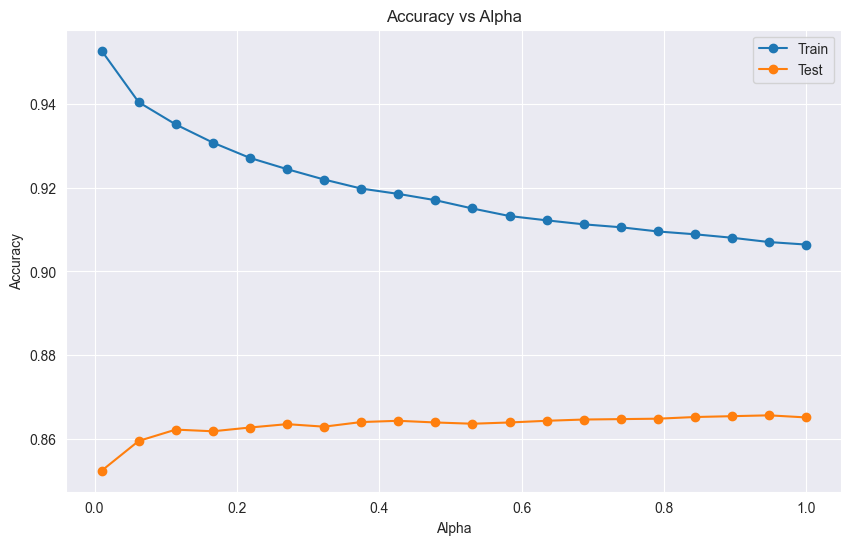

In [19]:
# Plot comparing the evolution of the accuracy for increasing values of alpha
alphas = np.linspace(0.01, 1, 20)

train_accuracies = []
test_accuracies = []

for alpha in alphas:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train_vect, y_train)
    y_train_prediction = nb.predict(X_train_vect)
    y_test_prediction = nb.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(alphas, train_accuracies, marker='o', label='Train')
plt.plot(alphas, test_accuracies, marker='o', label='Test')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')
plt.legend()
plt.show()

In the above plot, we can see that the model's test accuracy doesn't improve drastically after `alpha = 0.1`. However, the best alpha value would be around `0.45` as the GridSearchCV suggests. This can be justified by the fact that in that point, the train accuracy is still high but doesn't overfit the data. Actually, alphas starting at 0.25 would be already good, but the one chosen is the one who gives the best results in the test set. This way, the model will generalize better to unseen data.

When the alpha value is very low, the model is effectively memorizing the training data rather than learning generalizable patterns. This means the model performs well on the training data but fails to generalize new unseen test data. That's why the train accuracy is very high in the beginning. As the alpha value increases, the model is more regularized and that's why the train accuracy decreases and the test accuracy starts to learn patterns from the data.

### 3.3: Logistic Regression

The third model we're going to test is the [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

#### 3.3.1: Model creation

In [58]:
# Import the Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

In [59]:
# Create the Logistic Regression Classifier
lr = LogisticRegression(max_iter=1000)

# Train the model
lr.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = lr.predict(X_train_vect)
y_test_prediction = lr.predict(X_test_vect)

# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Logistic Regression", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Logistic Regression,0.933475,0.8942,0.933867,0.89668,Default parameters


#### 3.3.2: Model tuning

In the case of Logistic Regression, the most important parameter to tune is the `C` parameter, which is the inverse of the regularization strength. The smaller the value of `C`, the stronger the regularization.

In [60]:
# Find the best C using GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 20)
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_lr = grid_search.best_estimator_

# Train the model with the best parameters
best_lr.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = best_lr.predict(X_train_vect)
y_test_prediction = best_lr.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.96765
Test Accuracy: 0.8984


In [61]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'C': np.float64(4.281332398719396)}


In [62]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Logistic Regression", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Logistic Regression,0.96765,0.8984,0.967676,0.900353,Best parameters found by GridSearchCV


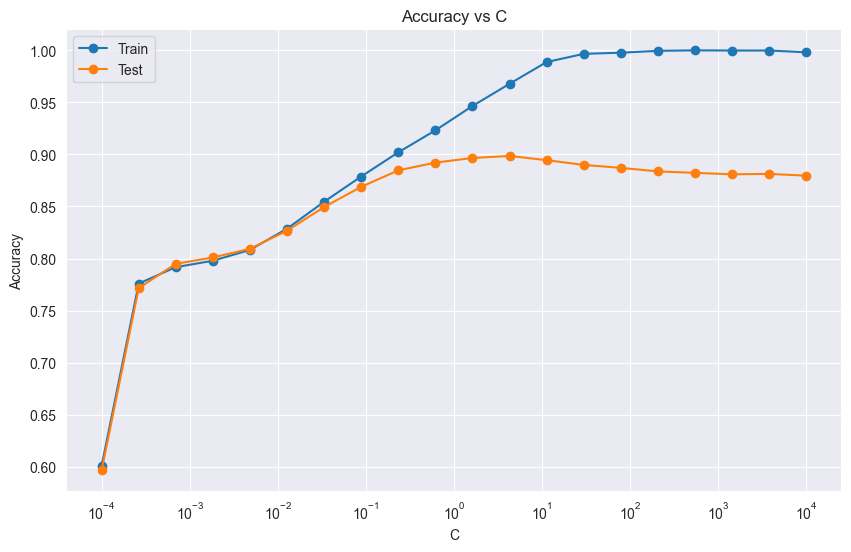

In [63]:
# Plot comparing the evolution of the accuracy for increasing values of C
Cs = np.logspace(-4, 4, 20)

train_accuracies = []
test_accuracies = []

for C in Cs:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(X_train_vect, y_train)
    y_train_prediction = lr.predict(X_train_vect)
    y_test_prediction = lr.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(Cs, train_accuracies, marker='o', label='Train')
plt.plot(Cs, test_accuracies, marker='o', label='Test')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()

plt.xscale('log')
plt.show()

In this plot we can observe the following insights:

1. <u>Low C</u> ($C = 10^{-4}$ to $10^{-2}$): 
    * The training accuracy is very low, indicating **underfitting**. The model is overly simplified and cannot caputre the complexity of the data.
    * Test accuracy also low in this region, showing that it doesn't generalize well.

2. <u>Moderate C</u> ($C = 10^{-1}$ to $C \approx 4.28$):
    * Both training and test accuracies increase as C grows, suggesting the model is better at capturing the data patterns without overfitting.
    * Around C = 4.28, the test accuracy reaches its peak, and the training accuracy is close to the test accuracy, indicating **good generalization**.

3. <u>High C</u> ( $C \gt 4.28$):
    * The training accuracy approaches 100%, indicating **overfitting** (the model fits the training data too closely).
    * The test accuracy plateaus or slightly declines, showing the model's inability to generalize well to unseen data.


### 3.4 Neural Networks

In [64]:
try:
    import torch
except ImportError:
    %pip install torch


#### 3.4.1 Model Creation

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare the data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train).toarray()  # Convert to numpy array
X_test_vect = vectorizer.transform(X_test).toarray()

y_train_torch = torch.tensor((y_train == 'positive').astype(int).values, dtype=torch.float32) # Convert to tensor to use it in PyTorch
y_test_torch = torch.tensor((y_test == 'positive').astype(int).values, dtype=torch.float32)

X_train_torch = torch.tensor(X_train_vect, dtype=torch.float32) 
X_test_torch = torch.tensor(X_test_vect, dtype=torch.float32)

# Define the model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create the model
input_dim = X_train_torch.shape[1]
model = SentimentClassifier(input_dim)

# Define the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss since we have a binary classification problem
optimizer = optim.Adam(model.parameters(), lr=0.00001)

#### 3.4.2 Model Tuning

Epoch 1/25, Loss: 0.6923, Train Accuracy: 0.5011, Test Accuracy: 0.4961
Epoch 2/25, Loss: 0.6693, Train Accuracy: 0.7906, Test Accuracy: 0.7640
Epoch 3/25, Loss: 0.6502, Train Accuracy: 0.8726, Test Accuracy: 0.8455
Epoch 4/25, Loss: 0.6317, Train Accuracy: 0.8941, Test Accuracy: 0.8702
Epoch 5/25, Loss: 0.5659, Train Accuracy: 0.9011, Test Accuracy: 0.8761
Epoch 6/25, Loss: 0.5545, Train Accuracy: 0.9078, Test Accuracy: 0.8805
Epoch 7/25, Loss: 0.4752, Train Accuracy: 0.9131, Test Accuracy: 0.8821
Epoch 8/25, Loss: 0.4135, Train Accuracy: 0.9171, Test Accuracy: 0.8851
Epoch 9/25, Loss: 0.3967, Train Accuracy: 0.9208, Test Accuracy: 0.8880
Epoch 10/25, Loss: 0.3752, Train Accuracy: 0.9242, Test Accuracy: 0.8895
Epoch 11/25, Loss: 0.2953, Train Accuracy: 0.9277, Test Accuracy: 0.8920
Epoch 12/25, Loss: 0.2620, Train Accuracy: 0.9312, Test Accuracy: 0.8937
Epoch 13/25, Loss: 0.2198, Train Accuracy: 0.9342, Test Accuracy: 0.8950
Epoch 14/25, Loss: 0.2641, Train Accuracy: 0.9370, Test Accu

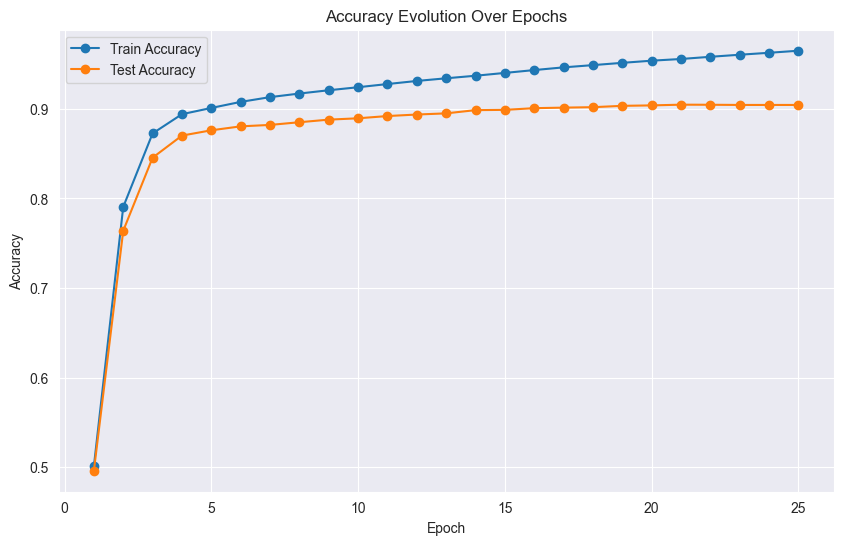

In [66]:
# Train the model

train_accuracies = []
test_accuracies = []

epochs = 25
batch_size = 64

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_torch.size(0))
    for i in range(0, X_train_torch.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_torch[indices], y_train_torch[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Evaluate the model at the end of each epoch
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_torch).squeeze()
        train_predictions = (train_predictions > 0.5).float()
        train_acc = accuracy_score(y_train_torch, train_predictions)
        
        test_predictions = model(X_test_torch).squeeze()
        test_predictions = (test_predictions > 0.5).float()
        test_acc = accuracy_score(y_test_torch, test_predictions)
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# After training is completed, plot the accuracies
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy Evolution Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
train_predictions = ['positive' if pred == 1.0 else 'negative' for pred in train_predictions]
test_predictions = ['positive' if pred == 1.0 else 'negative' for pred in test_predictions]
add_to_df(y_train, train_predictions, y_test, test_predictions, "Neural Network", "Best parameters found by manual tests")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Neural Network,0.964925,0.9044,0.964917,0.905831,Best parameters found by manual tests


Looking at the results, metrics show that the Neural Network model is the best one so far, along with the tuned Logistic Regression model. The gap between the train and test accuracies is minimal, which means that the model is generalizing well to unseen data, however if there was a higher gap, it would mean overfitting.

About the plot, we can differentiate three regions:

- **Initial growth**: At the start (the first few epochs), accuracy rapidly increases from around 65% to 85%-90%. This steep climb indicates that the model quickly learns basic distinctions between positive and negative reviews.
- **Plateauing**: After about 5-10 epochs, the accuracy improvements slow down, and the curves begin to plateau. The training accuracy continues to rise gradually, while the test accuracy flattens out around 90%.
- **Stable performance**: By the end of 25 epochs, both training and test accuracies have plateaued. This suggests that additional epochs without further adjustments (such as changes in learning rate, regularization, or architecture) may not yield significant improvements.
Early stopping or tuning hyperparameters might improve generalization slightly, but the model already has strong performance.

In [68]:
def predict_sentiment(text, model, vectorizer):
    """
    Performs sentiment prediction on a given text.
    
    Args:
        text (str): Input text to predict.
        model (torch.nn.Module): Trained model.
        vectorizer (TfidfVectorizer): Trained vectorizer to transform the text.
    
    Returns:
        str: Prediction ('positive' or 'negative').
    """
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():
        # Transform the text into features using the vectorizer
        text_vectorized = vectorizer.transform([text]).toarray()
        text_tensor = torch.tensor(text_vectorized, dtype=torch.float32)
        
        # Make the prediction
        output = model(text_tensor).item()
        prediction = 'positive' if output > 0.5 else 'negative'
        return prediction

### 3.5: Recurrent Neural Networks

A **Recurrent Neural Networks** (RNNs) is a class of neural networks designed for <u>processing sequential data</u>. Unlike feed-forward networks (which assume inputs are independent of each other), RNNs **maintain a hidden state** that captures information about previously seen elements in the sequence.

This hidden state is passed along as the network processes each time step, allowing it to accumulate context and dependencies from earlier parts of the input.

As seen in the <u>last slide</u> of the RNNs uploaded on the [CSC461 GitHub repository](https://github.com/URI-CSC/461-fall-2024/blob/main/lectures/26-rnns.key.pdf), by default the RNNs are not able to capture long-term dependencies as the gradients tend to vanish or explode as they are backpropagated through time. This is known as the **vanishing/exploding gradient problem**. This is why we are going to use the **LSTM** (Long Short-Term Memory) architecture, which is designed to address this issue.<br>
The LSTM architecture includes **gates** that control the flow of information into and out of the cell, allowing it to **retain information over long sequences**.

To be precise, we have implemented a **Bidirectional LSTM**. This architecture processes the input sequence in both forward and backward directions, allowing the model to capture dependencies from both past and future elements in the sequence.

After the LSTM outputs a sequence of hidden states, an **atention mechanism** is applied. The model learns to focus on specific parts of the sequence that are most relevant for the final classification. The attention weights highlight these important parts, and a weighted sum of the hidden states is taken.

Apart from that, we have downloaded the **GloVe** embeddings. Basically, in **Natural Language Processing**, words need to be represented as numeric vectors for the neural network to process them. An embedding is a dense, low-dimensional vector representation of words (or tokens), where semantic relationships between words are captured. Words with similar meanings or contexts tend to have similar embeddings in vector space.

We have uses the pre-trained GloVe embeddings as they have been trained already on large corpus such as *Wikipedia*. This gives the model a head start in understanding the relationships between words, and it can focus on learning the specific patterns in the *IMDB reviews*.

In the code from below, the embedding layer's weights are initialized with GloVe vectors for all words in the vocabulary found in the pre-trained embeddings. Words not found in the pre-trained embeddings are initialized randomly.

In [ ]:
# Try to import nltk, if it fails, install it
try:
    import nltk
    nltk.download('punkt')
    nltk.download('punkt_tab')
except ImportError:
    %pip install nltk
    nltk.download('punkt')

In [15]:
import os
import copy
from torch.utils.data import Dataset, DataLoader, random_split
from nltk.tokenize import word_tokenize
import nltk

# Ensure necessary NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# 1. Build Vocabulary from Training Data
def build_vocab(texts, max_vocab_size=20000, min_freq=2):
    freq = {}
    for txt in texts:
        for token in word_tokenize(txt.lower()):
            freq[token] = freq.get(token, 0) + 1
    sorted_tokens = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    sorted_tokens = [t for t, f in sorted_tokens if f >= min_freq][:max_vocab_size - 2]
    vocab = {'<PAD>': 0, '<UNK>': 1} # PAD for padding, UNK for unknown words
    for i, token in enumerate(sorted_tokens, start=2):
        vocab[token] = i
    return vocab

vocab = build_vocab(X_train)

# 2. Encode Text
max_length = 300
def encode_text(text, vocab, max_length=300):
    tokens = word_tokenize(text.lower())
    encoded = [vocab.get(t, 1) for t in tokens]  # 1 is <UNK>
    if len(encoded) < max_length:
        encoded += [0] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]
    return encoded

X_train_encoded = np.array([encode_text(review, vocab, max_length) for review in X_train])
X_test_encoded = np.array([encode_text(review, vocab, max_length) for review in X_test])

y_train_enc = (y_train == 'positive').astype(int).values
y_test_enc = (y_test == 'positive').astype(int).values

# 3. Create Dataset and Dataloaders
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

full_train_dataset = IMDBDataset(X_train_encoded, y_train_enc)
test_dataset = IMDBDataset(X_test_encoded, y_test_enc)

# Create a validation split from the training set
train_size = int(len(full_train_dataset) * 0.8)
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Load Pretrained GloVe Embeddings
embedding_dim = 100
glove_path = "glove.6B/glove.6B.100d.txt"  # For us, this is the path to the GloVe file, it might be different for you

# IMPORTANT:
# We haven't been able to upload the GloVe file to the GitHub repository due to its size
# You can download the GloVe file from https://nlp.stanford.edu/projects/glove/ , in the 
# section: "Download pre-trained word vectors" (glove.6B.zip) and extract the file glove.6B.100d.txt

word2vec = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        split_line = line.strip().split()
        word = split_line[0]
        vec = np.array(split_line[1:], dtype=np.float32)
        word2vec[word] = vec

# Build embedding matrix for our vocabulary
vocab_size = len(vocab)
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim)).astype(np.float32)

for word, idx in vocab.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]

# 5. Define the Bidirectional LSTM Model with Attention
class AttnLSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=2, dropout=0.5):
        super(AttnLSTMSentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, _ = self.lstm(embedded)
        # Apply attention
        attn_weights = torch.tanh(self.attention(lstm_output)).squeeze(2)
        attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(2)
        attn_output = torch.sum(lstm_output * attn_weights, dim=1)
        attn_output = self.dropout(attn_output)
        out = self.fc(attn_output)
        out = self.sigmoid(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttnLSTMSentimentClassifier(
    vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.5
).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# 6. Function to Evaluate Accuracy
def compute_accuracy(model, loader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
            outputs = model(X_batch).squeeze()
            p = (outputs > 0.5).long().cpu().numpy()
            preds.extend(p)
            labels.extend(y_batch.cpu().numpy())
    return accuracy_score(labels, preds)

# 7. Training Loop with Early Stopping, Gradient Clipping, and Learning Rate Scheduler
epochs = 20
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
best_model_weights = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
        y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    avg_train_loss = total_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    avg_val_loss = val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Compute accuracies
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    test_acc = compute_accuracy(model, test_loader)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered!")
            break

# Load the best model weights (early stopping)
model.load_state_dict(best_model_weights)

# Evaluate final performance
final_train_acc = compute_accuracy(model, train_loader)
final_val_acc = compute_accuracy(model, val_loader)
final_test_acc = compute_accuracy(model, test_loader)
print(f"Final Train Acc: {final_train_acc:.4f}, "
      f"Final Val Acc: {final_val_acc:.4f}, "
      f"Final Test Acc: {final_test_acc:.4f}")

# Plot training and validation losses
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Prepare data for adding to DataFrame
# Collect predictions and true labels for the training set
train_preds = []
train_true_labels = []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch).squeeze()
        preds = (outputs > 0.5).long().cpu().numpy()
        train_preds.extend(preds)
        train_true_labels.extend(y_batch.cpu().numpy())

# Convert predictions and labels to 'positive' or 'negative'
train_pred_labels = np.array(['positive' if p == 1 else 'negative' for p in train_preds])
train_true_labels = np.array(['positive' if y == 1 else 'negative' for y in train_true_labels])

# Collect predictions and true labels for the test set
test_preds = []
test_true_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch).squeeze()
        preds = (outputs > 0.5).long().cpu().numpy()
        test_preds.extend(preds)
        test_true_labels.extend(y_batch.cpu().numpy())

test_pred_labels = np.array(['positive' if p == 1 else 'negative' for p in test_preds])
test_true_labels = np.array(['positive' if y == 1 else 'negative' for y in test_true_labels])

# Assume add_to_df function and df are already defined
add_to_df(
    train_true_labels,
    train_pred_labels,
    test_true_labels,
    test_pred_labels,
    "Bidirectional LSTM with Attention",
    "Increased complexity, adjusted hyperparameters"
)

C:\Users\JVS\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended t

Epoch [1/20] - Train Loss: 0.6096, Val Loss: 0.5183, Train Acc: 0.7559, Val Acc: 0.7539, Test Acc: 0.7563


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [2/20] - Train Loss: 0.4505, Val Loss: 0.4247, Train Acc: 0.8149, Val Acc: 0.8080, Test Acc: 0.8036


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [3/20] - Train Loss: 0.3913, Val Loss: 0.3739, Train Acc: 0.8461, Val Acc: 0.8345, Test Acc: 0.8328


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [4/20] - Train Loss: 0.3566, Val Loss: 0.3450, Train Acc: 0.8662, Val Acc: 0.8510, Test Acc: 0.8480


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [5/20] - Train Loss: 0.3264, Val Loss: 0.3246, Train Acc: 0.8758, Val Acc: 0.8580, Test Acc: 0.8559


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [6/20] - Train Loss: 0.3014, Val Loss: 0.3119, Train Acc: 0.8878, Val Acc: 0.8656, Test Acc: 0.8630


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:422: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppDat

Epoch [7/20] - Train Loss: 0.2875, Val Loss: 0.3026, Train Acc: 0.8962, Val Acc: 0.8744, Test Acc: 0.8693


C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.long).to(device)
C:\Users\JVS\AppData\Local\Temp\ipykernel_11348\1563266052.py:402: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)


KeyboardInterrupt: 

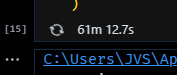

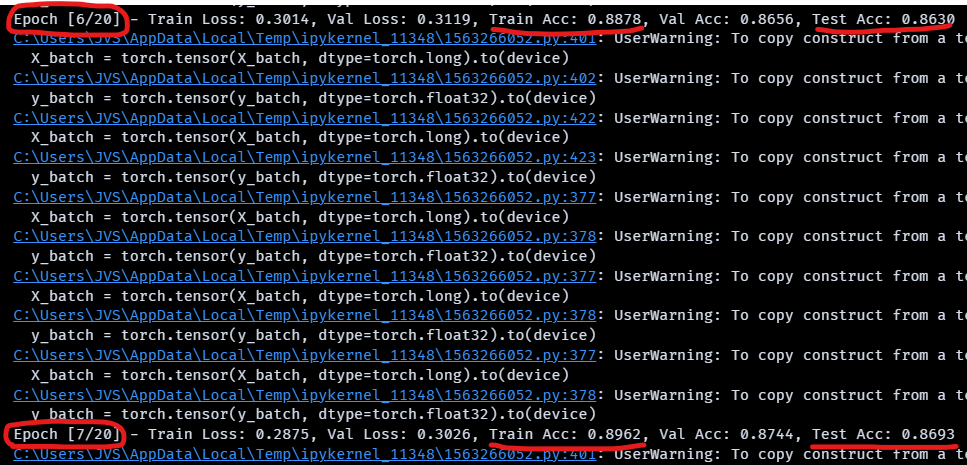

As we see in the previous execution/screenshot, after 1h of being running the code, the model just improved by *0.006* from the *6th to the 7th epoch*. This way, even though **Early stopping** is implemented in the code, we decided to stop the training earlier. The model is not overfitting, as the gap between the train and test accuracies is minimal, but the model is not learning much from the data either. This could be due to several reasons like:

- <u>Hidden size</u> of the LSTM <u>not being large enough</u>.
- <u>Insufficient</u> number of LSTM <u>layers</u>.
- <u>Inadequate tuning</u> of dropout, learning rate, or other hyperparameters.

If the model structure or hyperparameters aren't optimal, it may reach a performance plateau early.

> Note: As we have stopped manually the training, the final part of the code that plots the accuracy and loss curves hasn't been executed.

<u>We would have loved to test more configurations and hyperparameters, but due to the computational cost and time required, we just tested a few configurations and left this one as the final one.</u>

## Model testing

In [69]:
try:
    import gradio as gr
except ImportError:
    %pip install --upgrade gradio

In [70]:
def classify_reviews(texts):
    reviews = texts[:-2]
    percentage = texts[-2]
    model_choice = texts[-1]
    if model_choice == "Logistic Regression":
        results = [best_lr.predict(vectorizer.transform([review]))[0] for review in reviews]
    else:
        results = [predict_sentiment(review, model, vectorizer) for review in reviews]

    # Prepare individual results as a list of lists for the Dataframe
    individual_results = [[review, result] for review, result in zip(reviews, results)]

    # Determine overall recommendation
    if results.count('positive') >= len(results) * percentage / 100:
        overall_result = 'Recommendable'
    else:
        overall_result = 'Not recommendable'

    return overall_result, individual_results

# Define the number of reviews
rev_num = 10

# Create input components
input_boxes = [gr.Textbox(label=f"Review {i+1}") for i in range(rev_num)]
input_boxes.append(gr.Slider(minimum=0, maximum=100, label="Min. % of positive reviews", step=1))
input_boxes.append(gr.Dropdown(choices=["Logistic Regression", "Neural Networks"], label="Model Choice"))

# Gradio Interface
demo = gr.Interface(
    fn=lambda *args: classify_reviews(list(args)),
    inputs=input_boxes,
    outputs=[
        gr.Textbox(label="Overall Recommendation"),
        gr.Dataframe(headers=["Review", "Sentiment"], label="Individual Review Sentiments")
    ],
    title="Movie Recommendation Based On Reviews",
    description="Introduce text reviews for the model to decide if the movie is recommendable or not."
)

In [71]:
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7870
Running on public URL: https://696c92ee1a33067ed4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [72]:
# Select 10 random reviews
random_reviews = df_review.sample(n=10, random_state=42)

# Print the text and sentiment of the random reviews
for i, (review, sentiment) in enumerate(zip(random_reviews['review'], random_reviews['sentiment']), 1):
    print(f"Review {i}: {review}\nSentiment: {sentiment}\n")

Review 1: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna de

## Model comparison

Print the table with the performance of the models in order to visually see the differences between them.

In [41]:
# Print the dataframe with the results
df

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,1.000000,0.7265,1.000000,0.726363,Default parameters
1,Decision Tree,0.801775,0.7435,0.813457,0.759449,Best parameters found by GridSearchCV
2,Naive Bayes,0.906400,0.8652,0.904975,0.864604,Default parameters
3,Naive Bayes,0.916975,0.8640,0.915909,0.863891,Best parameters found by GridSearchCV
4,Logistic Regression,0.933475,0.8942,0.933867,0.896680,Default parameters
5,Logistic Regression,0.967650,0.8984,0.967676,0.900353,Best parameters found by GridSearchCV
6,Neural Network,0.964275,0.9044,0.964246,0.905720,Best parameters found by manual tests


It's actually quite common to see Logistic Regression perform exceptionally well on text classification tasks like IMDB sentiment analysis, especially when combined with strong feature representations like TF-IDF. Here are a few reasons why this happens and why your Neural Network might not have surpassed it by a large margin:

1. **<u>Suitability of Logistic Regression for High-Dimensional Sparse Data</u>**:
Logistic Regression thrives in high-dimensional, sparse feature spaces (exactly the kind of space produced by TF-IDF vectorization on large text datasets). It's a simple linear model that, with proper regularization (like tuning the parameter 'C'), can find a good linear decision boundary in a vast feature space. Sentiment classification on a large corpus often turns out to be quite linearly separable when represented by TF-IDF features.

2. **<u>Ease of Optimization</u>**:
Logistic Regression uses convex optimization, ensuring it finds a global optimum efficiently. This guarantees that the model leverages the available features extremely well and stably, often outperforming more complex models if they aren't carefully tuned.

3. **<u>Strong Baseline for Binary Classification</u>**:
In binary sentiment analysis, words or n-grams often strongly correlate with one sentiment or the other. This linear correlation is something Logistic Regression can exploit directly. The model tends to be surprisingly robust, forming a strong baseline that can be tough to beat unless you do more advanced feature engineering or model tuning.

4. **<u>Neural Networks Need More Careful Tuning and Better Feature Representations</u>**:
Neural Networks excel when there's non-linear structure to exploit or when you have richer input representations (like embeddings that capture semantic similarity between words). When fed raw TF-IDF vectors, a neural network doesn't gain as much advantage from its representational capacity. Without careful hyperparameter tuning (network depth, layer sizes, dropout, learning rate schedules) and potentially more advanced embeddings (like pretrained word embeddings or transformer-based encodings), the neural network may not outperform a well-tuned Logistic Regression by a large margin.

5. **<u>Regularization and Simplicity</u>**:
Simpler models like Logistic Regression are often less prone to overfitting when properly regularized. Neural Networks, with their larger number of parameters, might slightly overfit or need additional techniques (dropout, early stopping, etc.) to close the gap.

## AI Usage

// 🎃 TODO: comentar que sobre todo para el tema de RNN hemos usado IA ya que apenas lo ha dado en calse, y como bien dijo ayer, nos dijo que usásemos IA y buscásemos videos en YT 